# Tasks 4 and 5 

In [8]:
# import os
# os.chdir('..')
os.getcwd()

'/Users/angelglh/Documents/github_angelglh/working_memory'

In [41]:
import os
import numpy as np
from array import array
import matplotlib.pyplot as plt
import importlib
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

from sklearn.metrics import accuracy_score

# Custom functions and modules
from src.utils.process_images import *
from src.utils.metrics import * 
from src.data_funs.task_loading import *
from src.data_funs.task_visualizing import *
from src.models import ConvLSTMClassifier

In [20]:
# Reload the packages
import src.utils.process_images
importlib.reload(src.utils.process_images)
importlib.reload(src.utils.metrics)
importlib.reload(src.data_funs.task_loading)
importlib.reload(src.data_funs.task_visualizing)
importlib.reload(src.models)

<module 'src.models' from '/Users/angelglh/Documents/github_angelglh/working_memory/src/models.py'>

## Visualize task 4 and 5 data

In [115]:
raw_MNIST = os.getcwd() + '/data/MNIST/raw'
sequence_length = 30

# Training data
training_MNIST = tasks4and5_Dataset_MNIST(is_train_data = True, 
                                     sequence_length=sequence_length,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/train-images-idx3-ubyte', raw_MNIST + '/train-labels-idx1-ubyte')
                    )

training_loader_MNIST = DataLoader(training_MNIST, batch_size=64, shuffle=True)


# Training and validation data

testing_all_MNIST = tasks4and5_Dataset_MNIST(is_train_data = False, 
                                     sequence_length=sequence_length,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/t10k-images-idx3-ubyte', raw_MNIST + '/t10k-labels-idx1-ubyte')
                    )

test_size = len(testing_all_MNIST) //2
testing_MNIST, valid_MNIST = random_split(testing_all_MNIST, [test_size, len(testing_all_MNIST) - test_size])

testing_loader_MNIST = DataLoader(testing_MNIST, batch_size=64, shuffle=True)
valid_loader_MNIST = DataLoader(valid_MNIST, batch_size=64, shuffle=True)


Training data ...


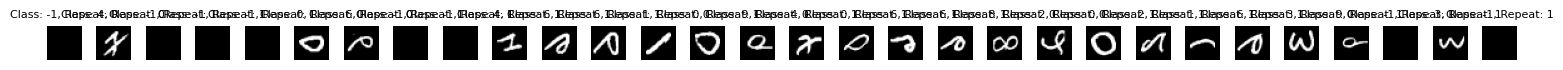

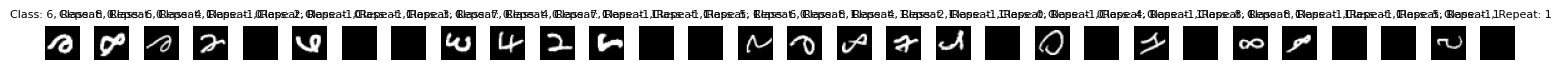


Testing data ...


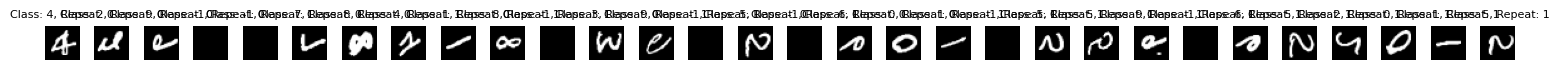

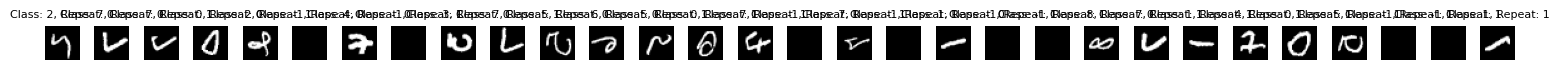


Validation data ...


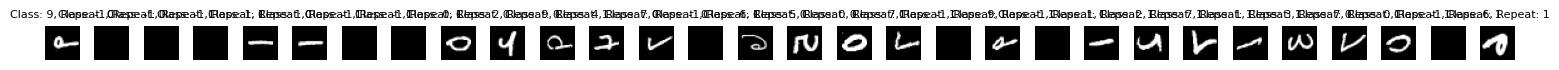

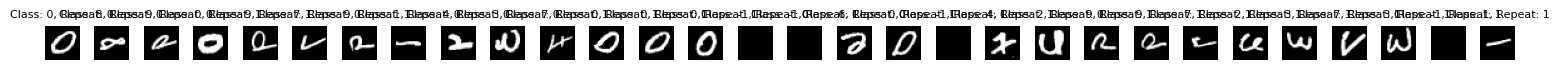

In [116]:
n_images_to_show = 2

# Visualize training, test and validation data
print("\nTraining data ...")
for sequences, class_labels, repeat_labels in training_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nTesting data ...")
for sequences, class_labels, repeat_labels in testing_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nValidation data ...")
for sequences, class_labels, repeat_labels in  valid_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

## 2. Train a model able to detect repeat patterns 

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SequenceRepetitionDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, sequence_length, num_layers=1, dropout=0.0):
        """
        Args:
            input_dim (int): The number of expected features in the input `x`
            hidden_dim (int): The number of features in the hidden state `h`
            sequence_length (int): Length of the input sequence
            num_layers (int, optional): Number of recurrent layers (e.g., setting num_layers=2 means stacking two LSTMs together)
            dropout (float, optional): If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer
        """
        super(SequenceRepetitionDetector, self).__init__()
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shaped [batch_size, sequence_length, input_dim]
        """
        # LSTM layer
        # Output shape: [batch_size, seq_length, hidden_dim]
        lstm_out, _ = self.lstm(x)
        
        # Fully connected layer
        # Output is reshaped to [batch_size * sequence_length, hidden_dim] to apply the linear layer, then reshaped back
        # to [batch_size, sequence_length] to match the target shape
        lstm_out_reshaped = lstm_out.contiguous().view(-1, self.hidden_dim)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits

# Example initialization
input_dim = 1  # Assuming each timestep in your sequence is a scalar
hidden_dim = 128  # Size of the hidden layer, can be tuned
sequence_length = sequence_length  # Assuming fixed sequence length for simplicity, adjust as necessary
num_layers = 2  # Number of LSTM layers
dropout = 0.2  # Dropout rate

model = SequenceRepetitionDetector(input_dim, hidden_dim, sequence_length, num_layers, dropout)
print(model)


SequenceRepetitionDetector(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 20
early_stopping_patience = 3
best_val_loss = float('inf')

# Initialize the model
model.train()

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss() # ignore the black noise class to avoid biasing the model to the noise images
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loader_with_progress = tqdm(training_loader_MNIST, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    for i, (images, model_classes, repeats) in enumerate(train_loader_with_progress):
        # Move tensors to the configured device
        sequence = model_classes.unsqueeze(-1).float().to(device) 
        repeats = repeats.float().to(device) 

        # Forward pass
        outputs = model(sequence)
        
        loss = criterion(outputs, repeats)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the progress bar with the loss information
        train_loader_with_progress.set_postfix(loss=loss.item())


    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, model_classes, repeats in testing_loader_MNIST:
            sequence = model_classes.unsqueeze(-1).float().to(device) 
            repeats = repeats.float().to(device) 

            # Forward pass
            outputs = model(sequence)
            loss = criterion(outputs, repeats)
            test_loss += loss.item()

    test_loss /= len(testing_loader_MNIST)
    print(f'Testing Loss: {test_loss:.4f}')
    
    # Check if validation loss improved
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == early_stopping_patience:
        print('Early stopping triggered. Training stopped.')
        break

In [120]:
# Save the model (if needed)
models_directory = os.getcwd() + "/models"
torch.save(model.state_dict(), models_directory + "/model_LSTM_repeats.pt")

## 3. Evaluate the performance

Same as with tasks 2 and 3, the pretrained model in task 1 should return a good performance in terms of predicting the class of every image.

For this reason, we will focus on prediction the actual 

In [101]:
import numpy as np
import torch

def accuracy_of_binary_labels(model, valid_loader, device):
    model.eval()  # Set the model to evaluation mode
    individual_accuracies = []
    sequence_accuracies = []

    with torch.no_grad():
        for images, model_classes, repeats in valid_loader:
            sequence = model_classes.unsqueeze(-1).float().to(device) 
            repeats = repeats.float().to(device) 

            # Forward pass to get logits
            logits = model(sequence)

            # Apply a sigmoid function to convert logits to probabilities
            probabilities = torch.sigmoid(logits)

            # Convert probabilities to binary predictions based on a 0.5 threshold
            predictions = (probabilities > 0.5).int()  # Use .int() to convert from bool to int
            
            # Now we iterate over each sequence in the batch for accuracy calculations
            for seq_idx in range(predictions.shape[0]):
                sequence_predictions = predictions[seq_idx]
                sequence_repeats = repeats[seq_idx]

                # Calculate individual accuracy (at the timestep level)
                correct_predictions = (sequence_predictions == sequence_repeats).cpu().numpy()
                individual_accuracy = np.mean(correct_predictions)
                individual_accuracies.append(individual_accuracy)

                # Calculate whole sequence accuracy (correct if all timesteps are correct)
                correct_sequence = np.all(correct_predictions)
                sequence_accuracies.append(correct_sequence)

    # Calculate overall metrics
    overall_individual_accuracy = np.mean(individual_accuracies)
    overall_sequence_accuracy = np.mean(sequence_accuracies)

    return overall_individual_accuracy, overall_sequence_accuracy, predictions, repeats

In [119]:
individual_accuracy, sequence_accuracy, predictions, repeats = accuracy_of_binary_labels(model = model, 
                                                                  valid_loader= valid_loader_MNIST, 
                                                                  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                                                                  )

print(f'Individual repetition Accuracy: {individual_accuracy * 100:.2f}%')
print(f'Whole Sequence Accuracy: {sequence_accuracy * 100:.2f}%')

Individual repetition Accuracy: 99.97%
Whole Sequence Accuracy: 99.22%


In [18]:
## Let us address model trained on task one to be a good 
models_directory = os.getcwd() + "/models"

# initialize the model as in task 1
ignore_class = -1

input_dim = 1  # Grey images present only 1 channel
hidden_dim = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers
num_classes = 10 # Number of classes 

model_pretrained_task1 = ConvLSTMClassifier(input_dim, hidden_dim, num_layers, num_classes)

# Load the pretrained weights and biases
model_pretrained_task1.load_state_dict(torch.load(models_directory + "/model_task1_MNIST_classes.pt"))

model_pretrained_task1.eval()

ConvLSTMClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(3136, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
individual_accuracy, sequence_accuracy = accuracy_of_class_labels(model = model_pretrained_task1, 
                                                                  valid_loader= valid_loader_MNIST, 
                                                                  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
                                                                  noise_image_class = -1)

print(f'Individual Image Accuracy: {individual_accuracy * 100:.2f}%')
print(f'Whole Sequence Accuracy: {sequence_accuracy * 100:.2f}%')

Individual Image Accuracy: 95.26%
Whole Sequence Accuracy: 68.94%
